In [1]:
import pandas as pd 
#df = pd.read_excel("Financial_Info_SG_Firms.xlsx", sheet_name="DATA_WORLDSCOPE_TS")
df = pd.read_csv("time series .csv")

#drop empty columns 
df = df.dropna(axis=1, how='all')

#drop columns with only 1 value for each company 
for col in df.columns:
    if col != 'Worldscope Permanent ID' and col!= 'Year' and len(df[col].unique()) <= len(df['Worldscope Permanent ID'].unique()):
        df.drop(col,inplace=True,axis=1)

#drop redundant column 
df = df.drop(['DS_CODE'], axis=1)

#combining the Year and Worldscope Permanent ID column so that we can drop rows with no values for all columns
df.Year=df.Year.astype(str)
df['idandyear'] = df[['Worldscope Permanent ID', 'Year']].agg('-'.join, axis=1)
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]
df = df.drop(['Worldscope Permanent ID', 'Year'], axis=1)
df = df.set_index('idandyear')
df = df.dropna(axis=0, how="all")
df = df.reset_index()
df[['Worldscope Permanent ID','Year']] = df.idandyear.str.split("-",expand=True)
df = df.drop(['idandyear'], axis=1)
cols = df.columns.tolist()
cols = cols[-2:] + cols[:-2]
df = df[cols]
df = df.drop_duplicates()

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
#rank the companies by the number of years worth of data they have
df['Worldscope Permanent ID'].value_counts().head(50)

C458AD990    36
C702H1590    36
C702AV920    36
C458AV830    36
C702H1860    36
C702H1410    36
C344V1280    36
C70254550    36
C45800110    36
C702H1700    36
C45852720    36
C702H1370    36
C702H1870    36
C344E1610    36
C826A8150    36
C45852840    36
C702H1820    36
C45852730    36
C458AV690    36
C702AW970    36
C392X3240    36
C344E1690    36
C392W1280    36
C45882470    36
C45882310    36
C702H1440    36
C702P2070    36
C458Y1270    36
C702AY040    36
C70257560    36
C45852900    36
C45852910    36
C702H1710    36
C702H1960    36
C702H1460    36
C702H1920    36
C702W3470    36
C702W3430    36
C392AI490    36
C702H1690    36
C45882370    36
C458C2090    36
C702H1500    36
C458C1820    36
C344AQ800    36
C344E1820    36
C702W3730    36
C702AW990    35
C702AV900    35
C702AF940    35
Name: Worldscope Permanent ID, dtype: int64

In [3]:
#trying to do forecasting on a company 
new_df = df[df['Worldscope Permanent ID'] == 'C45852720']
new_df = new_df.dropna(axis=1, how='all')

for col in new_df.columns:
    if len(new_df[col].unique()) != 36:
        new_df.drop(col,inplace=True,axis=1)
        
print(new_df.columns)

Index(['Year', 'Accumulated Depreciation % Gross Fixed Assets',
       'Capital Expenditures (Additions To Fixed Assets)',
       'Book Value Per Share', 'Book Value Outstanding Shares Fiscal',
       'Capital Expenditure % Total Sales', 'Cash & Short Term Investments',
       'Cash & Equivalents Generic', 'Common Equity', 'Common Equity (U.S.$)',
       'Common Equity % Total Assets', 'Cash Flow/Sales',
       'Cash Dividends % Cash Flow', 'Current Assets Total',
       'Current Liabilities Total', 'Depreciation, Depletion And Amortization',
       'Depreciation And Depletion',
       'Depreciation, Depletion & Amortization Cash Flow',
       'Dividend Yield Close', 'Earnings Per Share',
       'Earnings Before Interest And Taxes (EBIT)',
       'Earnings Before Interest, Taxes & Depreciation (EBITDA)',
       'Earnings Per Share Basic Year', 'Earnings Per Share Basic Fiscal',
       'Earnings Per Share Fiscal Year End', 'Enterprise Value',
       'Fixed Assets % Common Equity', 'Fund

In [4]:
df2 = new_df[['Year', 'Earnings Per Share']]
df2

,Year,Earnings Per Share
17496,1980,0.103
17497,1981,0.074
17498,1982,0.082
17499,1983,0.095
17500,1984,0.093
17501,1985,0.083
17502,1986,0.125
17503,1987,0.122
17504,1988,0.158
17505,1989,0.195


## Price/Earnings Ratio 
P/E Ratio Close = Market Price Year End / Earnings Per Share 

Indicates the dollar amount an investor can expect to invest in a company in order to expect a dollar of that company's earnings. It shows how much an investor is willing to pay for a dollar of earnings. A high P/E ratio could indicate that the stock is overvalued while the opposite could suggest an undervaluation. This could then aid investors in their decision to purchase a stock.

## Earnings Per Share 
EPS = Net Income / Common Shares Outstanding

It is a profitability ratio and indicates how much a company makes for each share of its stock. A higher EPS indicates more value because investors will pay more for a company with higher profits. 

In [6]:
import time
stm = time.time()
import os
#import numpy as np
import pandas as pd
#from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.api import ExponentialSmoothing, Holt #sometimes failed on Azure server
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as pl
%matplotlib inline
pl.rcParams["figure.figsize"] = [6.000, 6.145] #for square plot when x & y have identical ranges (else no guarantee)
pl.rcParams['lines.linewidth'] = 1.5
#pl.scatter(x, y, s=3, linewidths=0) #for dense plot, might have to set s=1 for smallest dots
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 31em; }</style>")) #31=ideal height of output window? else too short for plots

def hdtl(df, period1, d, nr=3):
    #display nr columns, and first & last nr rows of df:
    #period1 is periodicity of df, e.g. 12 for Yearly
    #d is frequency string, e.g. 'Y' for Yearly
    #d = 'daily' if freq1 == 'D' else "'"+freq1+"'"
    #print("'"+list(df)[0]+"'", 'is a daily time series with periodicity', str(period1)+'.')
    #print(("A '" if len(d) > 1 else "A ") + d +("'" if len(d) > 1 else ""), "time series with periodicity", str(period1),
    print("\nA '" + str(d) + "' time series with periodicity", str(period1), 'and length', str(df.shape[0])+':')
    #print(df.head(nr))
    #print(df.take([0], axis=1)[:nr]) #display 1st column's first nr values, with header but no footer
    #display 1st column's first nr values, with header but no footer:
    print(df.take(list(range(min(df.shape[1],nr))), axis=1)[:nr])
    #db = df[-nr:] #last nr rows
    db = df[-nr:][:] #bottom nr rows
    #db.rename(columns={c: '' for c in db}) #didn't work
    db.columns = [' '*len(c) for c in db.columns] #replace characaters in column names with blanks
    db.rename_axis('...', axis='index', inplace=True) #replace time index with '...'
    #db.iloc[-nr:,0] #will print footer
    #print(db.take([0], axis=1), '\n') #display 1st column's last 3 values
    print(db.take(list(range(min(db.shape[1],nr))), axis=1), '\n') #display 1st column's last 3 values
    
if 'df' in vars() or 'df' in globals():
    del df #delete df if defined during previous run

#>>>>> ENTER DATA HERE:

#time stamping this output:
import datetime
dtt = datetime.datetime.today()
print(dtt.strftime('%A') + ',', str(dtt).split()[0])

#specify data file and y variable:

#expects dates or time stamps in 1st column, and data in 2nd column; extra columns will be used for X-variables in ARIMAX:
#df = pd.read_excel(r"EnglandWalesBirths.xlsx", sheet_name=0) #reads 1st sheet
df = new_df[['Year', 'Earnings Per Share']]

df.dropna(how='all', inplace=True) #delete empty rows, probably at the start or end
df.dropna(axis=1, how='all', inplace=True) #delete empty columns

if not 'df' in vars():
    print('No dataset read in!')
    raise SystemExit
    
#if 'd' in vars() or 'd' in globals() or 'd' in vars(__builtins__):
if 'd' in vars() or 'd' in globals():
    del d #delete d if defined during previous run
if 'freq1' in vars() or 'freq1' in globals():
    del freq1

if len(list(df)) < 2:
    print('Column names are not in order:', list(df))
    raise SystemExit

if len(df) < 3:
    print(len(df), 'rows are not enough.')
    raise SystemExit

print('\nAnalysing "' + list(df)[1] + '"...')
hdtl(df, 'unknown', 'supposed') #display first & last 3 rows

a = list(df)[0] #1st column name
e = df.iloc[0,0] #1st element
#print(e)

#can 1st column become a Pandas timestamp (ie. is 1st column a time series)?
#if type(pd.date_range(e, periods=1)[0]) == pd._libs.tslibs.timestamps.Timestamp :
#is 1st element a timestamp?
try: #1st column must be timestamp
    if len(str(e)) == 4:
        pd.to_datetime(str(e), yearfirst=True)
    else:
        pd.to_datetime(str(e))
    #print('pd.to_datetime(e)', pd.to_datetime(e))
except:
    print('First column is not time-stamps!')
    #quit program:
    #quit() #doesn't work
    #os._exit(1) #doesn't work
    #exit() #doesn't work
    #sys.exit() #works, but requires 'import sys'
    raise SystemExit
#try and except makes sure things do not fall  

#without yearfirst=True, even a large number will essentially convert only to '1970-01-01':

if str((pd.to_datetime(str(e), yearfirst=True) if len(str(e)) == 4 else pd.to_datetime(str(e)))
       - pd.to_datetime('1970-01-01'))[ :15] == '0 days 00:00:00' :
    print('First column is not time-stamps!')
    raise SystemExit
    
else:
    #fill in any missing values from 3rd column onwards:
    i = df.iloc[:, 2:].isnull().sum().sum()
    if i > 0:
        q = list(df)[1] #column 2 name
        #df.loc[:, df.columns != q].interpolate(inplace=True) #would not extrapolate through .loc or .iloc !!
        col2 = df[q] #copy of column 2
        #above operates on all but the time-stamp column: end values are repeated; start values are not back-filled.
        df.interpolate(inplace=True)
        df[q] = col2 #reinstate column 2, the 'time series'
        j = i - df.iloc[:, 2:].isnull().sum().sum()
        if j > 0:
            print(j, 'of', i, 'missing exogenous X-variable values filled by interpolation.\n')
    
    #how many missing timestamps at the end of time-stamp column?
    i = 1
    while df[a][-i:][:1].isnull().sum() == 1:
        i = i + 1
    i = i - 1 #number of nan at the end
    if i > 0:
        print('Periods missing from the end of the time stamp:', i)
    #https://stackoverflow.com/questions/45352468/extending-timeindex-by-adding-new-values-in-another-column-in-pandas
    
    #set row labels as 1st column turned into dates:
    #df.set_index(df[a]) #does not confer time-series property
    #df.index = pd.DatetimeIndex(df[a], copy=False, freq='infer') #doesn't delete df[a]
    #c = df.iloc[1,0] - df.iloc[0,0]
    #nd = int(str(c)[0:str(c).find(' days')])
    #if nd > 9 and nd < 26: #should be around 16 days
    #    df.index = pd.DatetimeIndex(df[a], freq='SMS')
    #    #error message for above: 'Inferred frequency None from passed values does not conform to passed frequency SMS-15'
    #else:
    #    df.index = pd.DatetimeIndex(df[a], freq='infer') #doesn't set the frequency
    
    try:
        da = df[a].diff()[1:]
        if len(set(da)) == 1 and da.iloc[0] == 1:
            #assume yearly data
            #df[a] = df[a].apply(str) #convert numbers to strings
            df[a] = pd.to_datetime(df[a].apply(str), yearfirst=True)
            del da
    except:
        pass
    
    #making the timestamp column the index
    #df.index = pd.DatetimeIndex(df[a], freq='infer') #doesn't set the frequency if half-monthly
    df.index = pd.DatetimeIndex(df[a], freq='infer') #use first column as index 
    ##below can set the frequency wrongly!!!  Don't do it!!!  Disaster!!!  fills in NaT:
    #df.index = pd.date_range(start=df.index[0], periods=len(df.index), freq=df.index.freq)
    
    #delete time-stamp column:
    del df[a]
    
    #extend the index (row labels) to the end; preparing for ARIMA forecast with exogenous X-variables:
    #if i > 0 and df.index.freqstr != None:
    if i > 0:
        c = df.index[-i-1:][0] - df.index[-i-2:][0]
        c = str(c)[0:str(c).find(' days')]
        #while i > 0:
        #    df.index[-i:][0] = df.index[-i-1:][0] + j #Index does not support mutable operations
        #    i = i - 1
        try:
            nd = int(c)
            if nd == 14:
                freq1 = 'SMS-15' #1st and 15th of month
            elif nd == 15:
                freq1 = 'SMS-16' #1st and 16th of month
            #elif nd > 9 and nd < 26: #should be around 16 days
            #    freq1 = 'SMS-16' #15 days apart
            else:
                freq1 = df.index.freq
        except:
            freq1 = df.index.freq
            
        j = len(df.index.dropna())
        #df = pd.DataFrame(data=df, index=pd.date_range(start=df.index[0], periods=len(df.index) + i, freq=df.index.freq))
        df.index = pd.date_range(start=df.index[0], periods=len(df.index.dropna()) + i, freq=freq1)
        j =  len(df.index.dropna()) - j
        if j > 0:
            print("Time Index (row labels) '" + df.index.freqstr + "' extended by:", j)
            print(df.iloc[-j:,:1])
    
    if 'freq1' in vars():
        df.asfreq(freq1)
    #find periodicity:
    #see if frequency-string is set:
    if df.index.freqstr != None :
        freq1 = df.index.freqstr
        d = freq1
    else:
        freq1 = pd.infer_freq(df.index, warn=False) #inferred frequency from the data
        #'Y'ear, 'M'onth, 'W'eek, 'D'ay, 'B'usinesdays, 'H'our, 'T' Minute, 'S'econd, 'L' Millisecond, 'U' Microsecond,
        # 'N'anosecond, Annual: 'AS' 'BAS' 'A' 'BA', Quarterly: 'QS' 'BQS' 'Q' 'BQ', Monthly: 'MS' 'BMS' 'M' 'BM'
        if freq1 == None:
            d = freq1
        else:
            if len(freq1.strip()) > 1 :
                d = ''.join(c for c in freq1 if c not in 'BS') #remove 'B' & 'S'
            else:
                d = freq1
        d = 'daily' if (d == 'D' or d == 'B') else (d if d == None else "'"+str(d)+"'")
        print('Inferred frequency from the data:', d, '\n')
        if freq1 == None :
            c = df.index[1] - df.index[0]
            nd = int(str(c)[0:str(c).find(' days')])
            if nd > 9 and nd < 26: #should be around 16 days
                freq1 = 'SMS' #twice monthly; 15th (or other day_of_month) and calendar month begin
                d = freq1
            elif c == pd.Timedelta('1 days 00:00:00'):
                freq1 = 'D' #daily data
            elif c == pd.Timedelta('0 days 01:00:00'):
                freq1 = 'H' #hourly data
            elif c == pd.Timedelta('0 days 00:01:00'):
                freq1 = 'M' #minute-by-minute data
    #df.asfreq(freq=freq1) #might create extra rows filled with NaN
    if 'Y' in freq1 or 'A' in freq1:
        #Yearly; just set to decade:
        period1 = 10
    elif 'Q' in freq1:
        #Quarterly:
        period1 = 4
    elif 'M' in freq1 or 'SM' in freq1 or 'SMS' in freq1 or 'SMS-15' in freq1 or 'SMS-16' in freq1:
        #Monthly:
        period1 = 12
    #elif 'C' in freq1:
    #    #twice monthly:
    #    #period1 = 24
    #    period1 = 12
    #    freq1 = 'SMS'
    #    df.asfreq(freq1)
    #    d = freq1
    elif 'W' in freq1:
        #Weekly:
        period1 = 13 # 13*4 = 52
    elif 'D' in freq1:
        #Daily:
        b = df.index[7] - df.index[0]
        if b == pd.Timedelta('7 days 00:00:00'):
            period1 = 7 #weekly cycle
        elif b == pd.Timedelta('8 days 00:00:00'):
            period1 = 6 #6-day week
        elif b == pd.Timedelta('9 days 00:00:00') or b == pd.Timedelta('11 days 00:00:00'):
            period1 = 5 #5-day week
        else:
            print('Cannot find periodicity for this daily time series!  Defaulting to 5.')
            period1 = 5 #weekly cycle
    elif 'B' in freq1:
        #BusinessDays:
        period1 = 5
    elif 'H' in freq1:
        #Hourly:
        #period1 = 24 #highest
        period1 = 12 #highest periodicity
    elif 'T' in freq1 or 'S' in freq1:
        #by minuTe or Second:
        period1 = 15
    elif 'L' in freq1 or 'U' in freq1 or 'N' in freq1:
        #by miLli-, 'U' micro- or 'N'ano- second:
        period1 = 10
    else:
        #just set to 10:
        period1 = 10
pmax = 12 #highest periodicity

if df.index.freqstr == None:
    freq1 = None
    d = freq1

##2nd attempt to fill in any missing values:
#i = df.isnull().sum().sum()
#if i > 0:
    #df.interpolate(inplace=True)
#    j = i - df.isnull().sum().sum()
#    if j > 0:
#        print(j, 'of', i, 'missing values filled by interpolation.\n')

#fill any missing at start or end with nearest value, from column 2 onwards:
ts = list(df)[0]
tsh = 0 #number of missing at time series head
tst = 0 #number of missing at time series tail
#for j in list(df)[1:]: #not for time series in 1st column
for j in list(df):
    u1 = set(df[j].dropna())
    if len(u1) == 1:
        if j == ts: #1st column
            print('Time Series only has 1 unique value.  Cannot continue!')
            print(ts)
            raise SystemExit
            
        else:
            print("Deleted for having only 1 distinct value of '"+ str(list(u1)[0])+"':", df[j].name)
            del df[j]
    else:
        #head:
        i = 1
        while df[j][i-1:i].isnull().sum() == 1:
            i = i + 1
        i = i - 1 #number of nan at the start
        if i > 0:
            if j == ts:
                tsh = i
            else:
                naf = df[j][i:i+1].values[0]
                print(naf, 'replaced', i, 'missing values at the start of:', j)
                df[j][:i] = naf
        #tail:
        i = 1
        while df[j][-i:][:1].isnull().sum() == 1:
            i = i + 1
        #naf = df[j][-i:][:1].values[0]
        i = i - 1 #number of nan at the end
        if i > 0:
            if j == ts:
                tst = i
            else:
                naf = df[j][-i+1:][:1].values[0]
                print(naf, 'replaced', i, 'missing values at the end of:', j)
                df[j][-i:] = naf

#print('period1=',period1,", d=",d, ", freq1=", freq1)
hdtl(df, period1, d) #display first & last 3 rows
#print(df.iloc[:,:3]) #first 3 columns

if tsh > 0:
    #remove rows where time series is missing at the head:
    df = df.iloc[tsh:, :]
if tst > 0:
    #use only 1st column as time series:
    dt = df.iloc[:-tst, 0] #remove nan from the tail of 1st column
else:
    dt = df.iloc[:, 0]

i = dt.isnull().sum()
if i > 0:
    print('Interpolating for missing values in the middle of the time series.')
    dt.interpolate(inplace=True)
i = dt.isnull().sum()
if i > 0:
    print('Missing values cannot be removed!')
    print(dt)
    raise SystemExit

nr = dt.shape[0] #number of rows
nb = 68 #nbest; nb > 68 can result in x labels overlapping
npr = min(nr, nb) #npractical; the normal number of obs plotted

#data prep done

print(f'\033[1m' + 'Analysing "' + dt.name + '" as a', "'" + str(d) + "' time series with periodicity", str(period1), 'and length',
      str(dt.size) + ' ...' + f'\033[0m')

Sunday, 2020-04-05

Analysing "Earnings Per Share"...

A 'supposed' time series with periodicity unknown and length 36:
       Year  Earnings Per Share
17496  1980               0.103
17497  1981               0.074
17498  1982               0.082
                               
...                            
17529  2013               0.720
17530  2014               0.656
17531  2015               0.709 


A 'AS-JAN' time series with periodicity 10 and length 36:
            Earnings Per Share
Year                          
1980-01-01               0.103
1981-01-01               0.074
1982-01-01               0.082
                              
...                           
2013-01-01               0.720
2014-01-01               0.656
2015-01-01               0.709 

Interpolating for missing values in the middle of the time series.
Analysing "Earnings Per Share" as a 'AS-JAN' time series with periodicity 10 and length 36 ...


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Simple Exponential Fit:

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                   36
Model:             ExponentialSmoothing   SSE                              0.101
Optimized:                         True   AIC                           -207.476
Trend:                             None   BIC                           -204.309
Seasonal:                          None   AICC                          -206.186
Seasonal Periods:                  None   Date:                 Sun, 05 Apr 2020
Box-Cox:                          False   Time:                         15:52:18
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            1.0000000                alpha                 True
initial_

/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


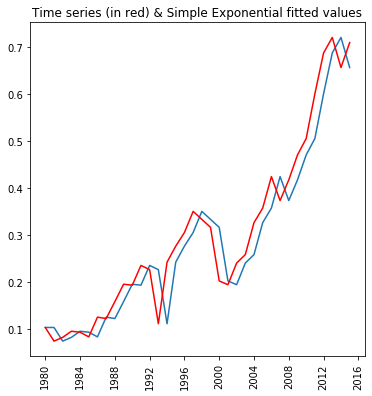


Last 10 observations:


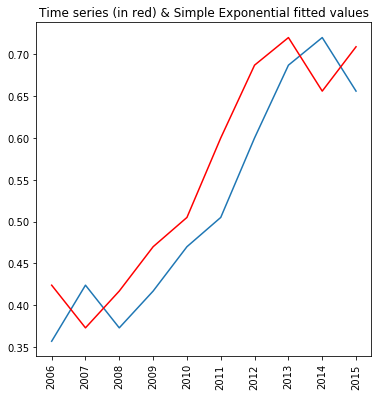


Simple Exponential Forecasts for 10 periods:
2016-01-01    0.709
2017-01-01    0.709
2018-01-01    0.709
2019-01-01    0.709
2020-01-01    0.709
2021-01-01    0.709
2022-01-01    0.709
2023-01-01    0.709
2024-01-01    0.709
2025-01-01    0.709
Freq: AS-JAN, dtype: float64


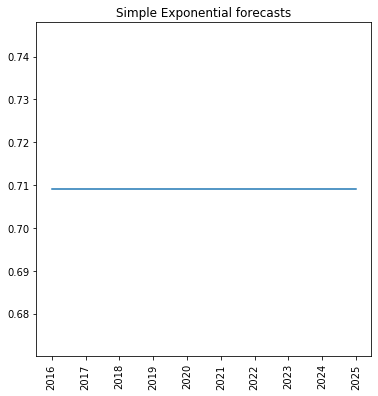


Holt's Double Exponential Fit:

                              Holt Model Results                              
Dep. Variable:                  endog   No. Observations:                   36
Model:                           Holt   SSE                              0.091
Optimized:                       True   AIC                           -207.435
Trend:                       Additive   BIC                           -201.101
Seasonal:                        None   AICC                          -204.539
Seasonal Periods:                None   Date:                 Sun, 05 Apr 2020
Box-Cox:                        False   Time:                         15:52:19
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.9765285                alpha                 True
smoothing_slope    

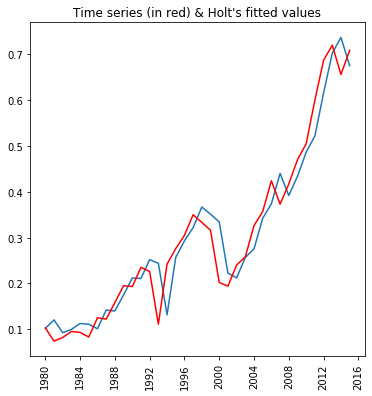


Last 10 observations:


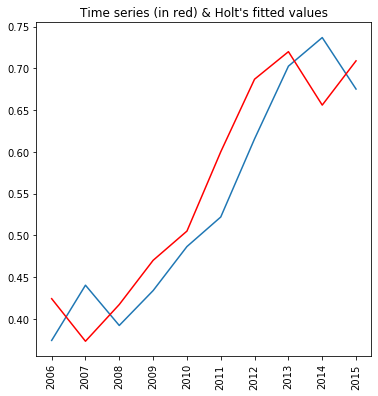


Holt's Forecasts for 10 periods:
2016-01-01    0.725530
2017-01-01    0.742853
2018-01-01    0.760176
2019-01-01    0.777499
2020-01-01    0.794821
2021-01-01    0.812144
2022-01-01    0.829467
2023-01-01    0.846790
2024-01-01    0.864113
2025-01-01    0.881436
Freq: AS-JAN, dtype: float64


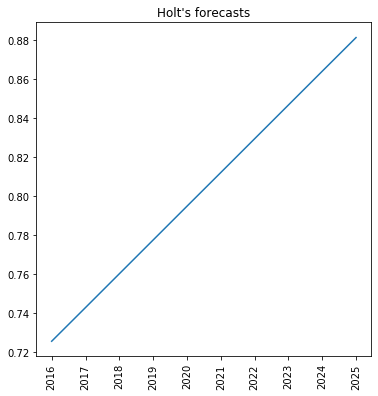


Winters' Triple Exponential Fit:

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                   36
Model:             ExponentialSmoothing   SSE                              0.204
Optimized:                         True   AIC                           -158.247
Trend:                         Additive   BIC                           -136.077
Seasonal:                Multiplicative   AICC                          -129.615
Seasonal Periods:                    10   Date:                 Sun, 05 Apr 2020
Box-Cox:                          False   Time:                         15:52:21
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.4210526                alpha            

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


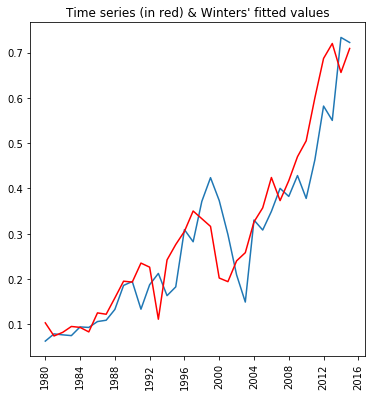


Last 10 observations:


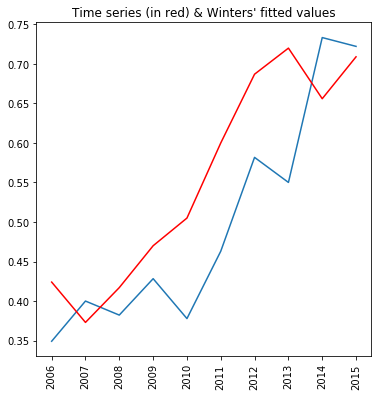


Winters' Forecasts for 10 periods:
2016-01-01    0.782737
2017-01-01    0.702106
2018-01-01    0.755507
2019-01-01    0.817113
2020-01-01    0.782109
2021-01-01    0.821498
2022-01-01    0.863974
2023-01-01    0.808300
2024-01-01    0.757695
2025-01-01    0.829821
Freq: AS-JAN, dtype: float64


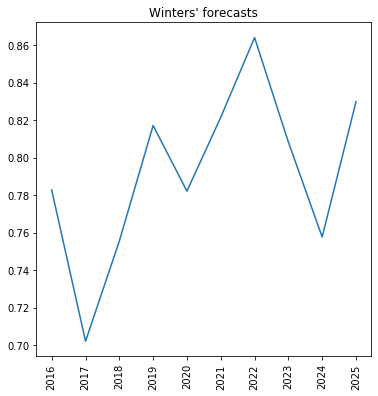


Multiplicative Holt's Double Exponential Fit:

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                   36
Model:             ExponentialSmoothing   SSE                              0.091
Optimized:                         True   AIC                           -207.109
Trend:                   Multiplicative   BIC                           -200.775
Seasonal:                          None   AICC                          -204.212
Seasonal Periods:                  None   Date:                 Sun, 05 Apr 2020
Box-Cox:                          False   Time:                         15:52:21
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.9426243                alpha        

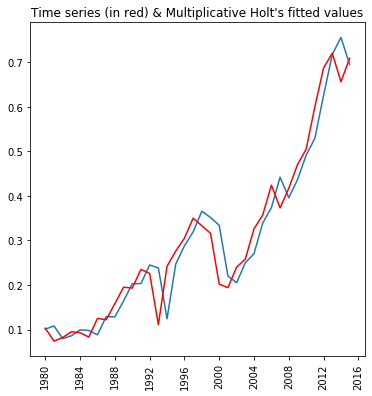


Last 10 observations:


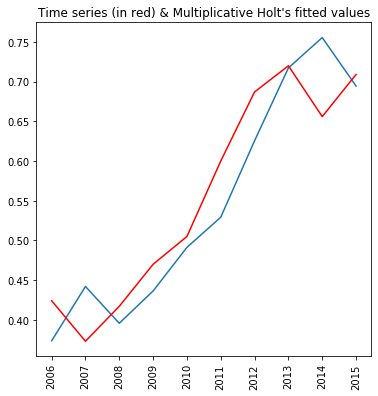


Multiplicative Holt's Forecasts for 10 periods:
2016-01-01    0.743285
2017-01-01    0.780142
2018-01-01    0.818827
2019-01-01    0.859430
2020-01-01    0.902046
2021-01-01    0.946776
2022-01-01    0.993723
2023-01-01    1.042999
2024-01-01    1.094717
2025-01-01    1.149001
Freq: AS-JAN, dtype: float64


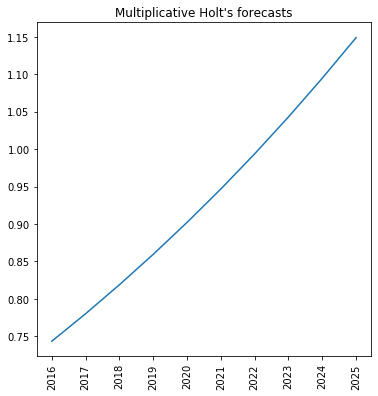

In [7]:
#single, double or triple exponential smoothing:

if 'md' in vars() or 'md' in globals() or 'md' in vars(__builtins__):
    del md #delete d if defined during previous run
for i in range(1,4):
    if i == 1:
        #Simple Exponential:
        #Tay Choon Wee solved the version-compatibility issue by adding .astype('double'):
        md = ExponentialSmoothing(dt.astype('double'), freq=freq1, seasonal_periods=period1, missing='raise')
        mtd = 'Simple Exponential'
    elif i == 2:
        #Holt's:
        #http://statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.Holt.html
        #md = ExponentialSmoothing(dt.astype('double'), trend='add', freq=freq1, seasonal_periods=period1)
        md = Holt(dt.astype('double'))
        mtd = "Holt's"
    else:
        #Winters':
        try:
            md = ExponentialSmoothing(dt.astype('double'), trend='add', seasonal='mul', freq=freq1, seasonal_periods=period1)
        except:
            #necesary for Azure server; changing to default seasonal='add', which means Holt's instead of Winters':
            md = ExponentialSmoothing(dt.astype('double'), trend='add', freq=freq1, seasonal_periods=period1)
            print("To get around a crash, done Holt's instead of Winters'.")
        mtd = "Winters'"

    mf = md.fit()

    if i == 1:
        print("\nSimple Exponential Fit:\n")
    elif i == 2:
        print("\nHolt's Double Exponential Fit:\n")
    else:
        print("\nWinters' Triple Exponential Fit:\n")

    print(mf.summary()) #no output on Azure server; only shows 'None'
    #print(np.array(list(mf.params.items())))
    print('\nLast', npr, 'observations:')
    pl.plot(mf.fittedvalues[-npr:])
    pl.plot(dt[-npr:], color='red')
    pl.xticks(rotation=90)
    pl.title('Time series (in red) & '+('Simple Exponential' if i==1 else ("Holt's" if i==2 else "Winters'"))+' fitted values')
    pl.show()
    
    if nr > period1:
        print('\nLast', period1, 'observations:')
        pl.plot(mf.fittedvalues[-period1:])
        pl.plot(dt[-period1:], color='red')
        pl.xticks(rotation=90)
        pl.title('Time series (in red) & '+('Simple Exponential' if i==1 else ("Holt's" if i==2 else "Winters'"))+' fitted values')
        pl.show()
    
    print('\n'+mtd, 'Forecasts for', period1, 'periods:')
    #forecast a full cycle:
    #prd = mf.predict(start=dt.shape[0], end=dt.shape[0]+period1-1)
    prd = mf.forecast(period1) #same as above
    print(prd)
    pl.xticks(rotation=90)
    pl.plot(prd)
    pl.title(('Simple Exponential' if i==1 else ("Holt's" if i==2 else "Winters'"))+' forecasts')
    pl.show()

if 'mf2' in vars() or 'mf2' in globals() or 'mf2' in vars(__builtins__):
    del mf2 #delete d if defined during previous run
    
#alternate Holt's, giving same results as earlier 'Double Exponential':
try:
    #mf2 = Holt(dt.astype('double')).fit()
    mf2 = ExponentialSmoothing(dt.astype('double'), trend='mul', freq=freq1, seasonal_periods=period1).fit()
except:
    #necesary for Azure server; changing to default trend='add', yielding same results as above Holt's:
    mf2 = ExponentialSmoothing(dt.astype('double'), freq=freq1, seasonal_periods=period1).fit()
    print("To get around a crash, done additive instead of multiplicative Holt's.")
    
print("\nMultiplicative Holt's Double Exponential Fit:\n")
#print(mf2.params.items())
print(mf2.summary())
print('\nLast', npr, 'observations:')
pl.plot(mf2.fittedvalues[-npr:])
pl.plot(dt[-npr:], color='red')
pl.xticks(rotation=90)
pl.title("Time series (in red) & Multiplicative Holt's fitted values")
pl.show()

if nr > period1:
    print('\nLast', period1, 'observations:')
    pl.plot(mf2.fittedvalues[-period1:])
    pl.plot(dt[-period1:], color='red')
    pl.xticks(rotation=90)
    pl.title("Time series (in red) & Multiplicative Holt's fitted values")
    pl.show()

print("\nMultiplicative Holt's Forecasts for", period1, "periods:")
prd = mf2.forecast(period1)
print(prd)
pl.xticks(rotation=90)
pl.plot(prd)
pl.title("Multiplicative Holt's forecasts")
pl.show()



Time Series Decomposition for 36 observations:


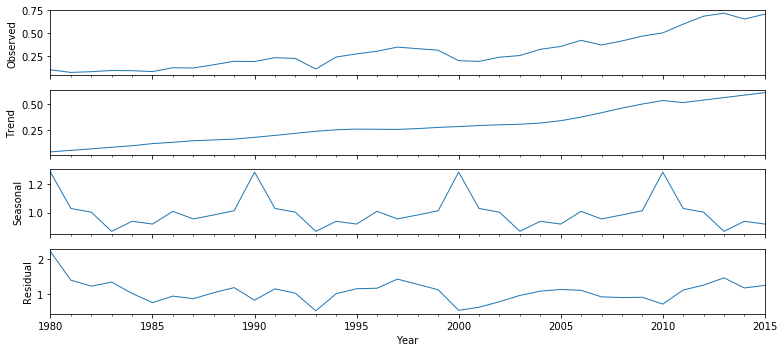

Last 36 observations (in red) & Multiplicative Decomposition fitted values:


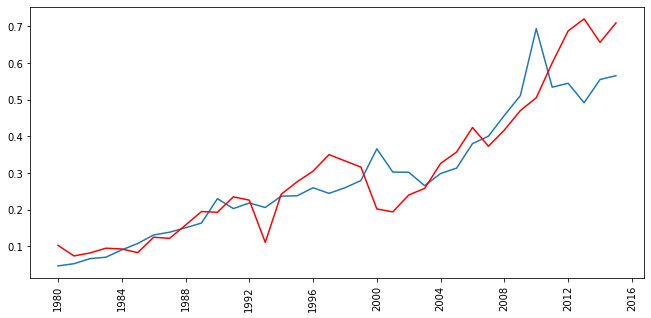

Last 10 observations (in red) & Multiplicative Decomposition fitted values:


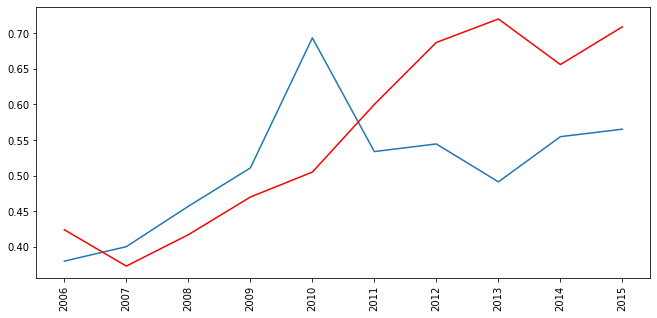

Last 10 fitted (non-forecast) trend values:


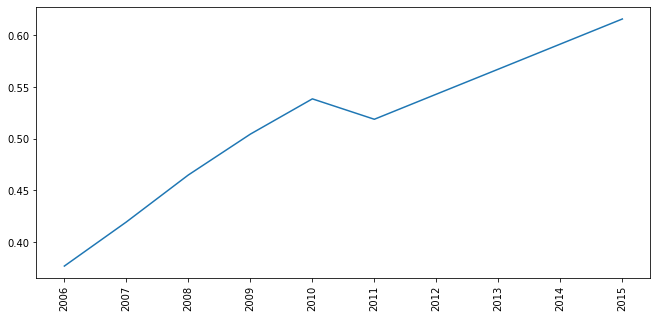

Last 10 fitted (non-forecast) seasonal indices:


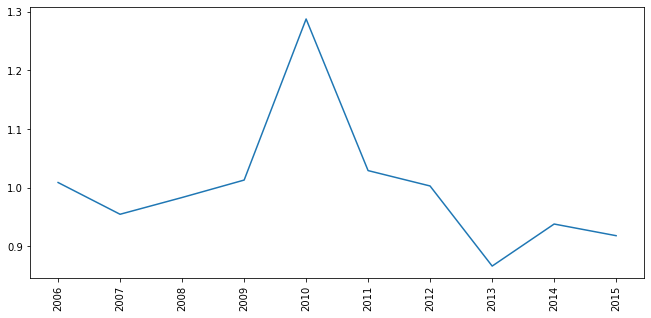

In [8]:
#decomposition:

if 'mf4' in vars() or 'mf4' in globals() or 'mf4' in vars(__builtins__):
    del mf4 #delete d if defined during previous run
mf4 = seasonal_decompose(dt, model='mul', freq=period1, extrapolate_trend='freq') #'extrapolate' removes NaN in 'trend'
print('\nTime Series Decomposition for', nr, 'observations:')
#pl.xticks(rotation=90) #doesn't work

#https://matplotlib.org/tutorials/introductory/customizing.html
pl.rcParams['figure.figsize'] = 11, 5
pl.rcParams['lines.linewidth'] = 1
pl.rcParams['lines.markersize'] = 1

mf4.plot()
pl.show()
mf4obs = mf4.observed.copy()
mf4trend = mf4.trend.copy()
mf4season = mf4.seasonal.copy()

t = 366 #tail # a year's worth of data 
if len(mf4.observed) > t:
    
    #mf4.observed = mf4.observed[-t:]
    mf4._observed = mf4._observed[-t:] #this trick took hours of trial & error to discover!!
    #mf4.trend = mf4.trend[-t:]
    mf4._trend = mf4._trend[-t:]
    #mf4.seasonal = mf4.seasonal[-t:]
    mf4._seasonal = mf4._seasonal[-t:]
    #mf4.resid = mf4.resid[-t:]
    mf4._resid = mf4._resid[-t:]
    
    #pl.xticks(rotation=90)
    print('Last', t, 'observations:')
    mf4.plot()
    pl.show()
    
t = 53 #tail #53 is about a year's worth of data if you have weekly data 
if len(mf4.observed) > t:
    mf4._observed = mf4._observed[-t:]
    mf4._trend = mf4._trend[-t:]
    mf4._seasonal = mf4._seasonal[-t:]
    mf4._resid = mf4._resid[-t:]
    #pl.xticks(rotation=90)
    print('Last', t, 'observations:')
    mf4.plot()
    pl.show()

pl.rcParams['lines.linewidth'] = 1.5
    
print('Last', npr, 'observations (in red) & Multiplicative Decomposition fitted values:')
pl.xticks(rotation=90)
pl.plot(mf4trend[-npr:] * mf4season[-npr:])
pl.plot(mf4obs[-npr:], color='red')
pl.show()

if len(mf4.observed) > period1:
    print('Last', period1, 'observations (in red) & Multiplicative Decomposition fitted values:')
    pl.xticks(rotation=90)
    pl.plot(mf4.trend[-period1:] * mf4.seasonal[-period1:])
    pl.plot(mf4.observed[-period1:], color='red')
    pl.show()
    
    #print('Last',period1,"trend values (may not have same time periods as 'observations' above and 'seasonal indices' below):")
    print('Last', period1, 'fitted (non-forecast) trend values:')
    pl.xticks(rotation=90)
    pl.plot(mf4.trend[-period1:])
    pl.show()
    
    print('Last', period1, 'fitted (non-forecast) seasonal indices:')
    pl.xticks(rotation=90)
    pl.plot(mf4.seasonal[-period1:])
    pl.show()

def ipl(ni, nr, nb, mf3, df, p, d, q, dx0=None, bcn=None):
    #index plot for ARIMAX fit
    ni = min(nr, ni, nb, mf3.nobs) #nb > 68 gets x labels overlapping
    lw = 1.0 if ni > 12 else None #linewidth
    print('\n'+('Last ' + str(ni) + ' of ' if ni < nr else '') + str(nr) + ' observations:')
    
    if 'dx' in vars() or 'dx' in globals():
        try:
            pd = mf3.predict(start=df.index[-ni], end=df.index[-1], exog=dx0[bcn], typ='levels')
        except:
            #print("Trying .predict() with exog= but without typ='levels'...")
            pd = mf3.predict(start=df.index[-ni], end=df.index[-1], exog=dx0[bcn])
            #gets perfect fit??
            
        r = pd.corr(dt[-ni:])
        pl.title('Time series (in red) & ARIMA('+str(p)+','+str(d)+','+str(q)+') (+ '+ str(len(bcn))+
                 ' X-variables) fitted values' + ('' if r != r else ' with r=' + str(round(r, 5))))
    else:
        try:
            pd = mf3.predict(start=df.index[-ni], end=df.index[-1], typ='levels')
            #cheats with dynamic=True; but better 'fit':
            #pl.plot(mf3.predict(start=df.index[-ni], end=df.index[-1], typ='levels', dynamic=True))
        except:
            #print("Trying .predict() without typ='levels'...")
            pd = mf3.predict(start=df.index[-ni], end=df.index[-1])
            
        r = pd.corr(dt[-ni:])
        pl.title('Time series (in red) & ARIMA('+str(p)+','+str(d)+','+str(q)+') fitted values' + 
                 ('' if r != r else ' with r=' + str(round(r, 5))))
        
    pl.plot(pd, linewidth=lw)
    pl.plot(dt[-ni:], color='red', linewidth=lw)
    #pl.xlabel('"' + xn + '" index') #could be a subset of y's index
    #pl.ylabel('"' + yn + '" range') #typically wider than y-fitted's range
    #pl.title('Index plot of ' + ('(last ' + str(ni) + ') ' if ni < nr else '') + '"' + yn + '" & "' + xn + '" (in red)')
    pl.xticks(rotation=90)
    pl.show()


In [26]:
#df = new_df[['Year', 'Earnings Per Share', 'Total Assets', 'Total Capital']]
#df = df.set_index('Year')

df = new_df[['Year', 'Earnings Per Share']]
df = df.set_index('Year')
df = pd.concat([df, df.shift(), df.shift(2)], axis=1)
df.columns = ['EPS', 'EPS Lag', 'EPS Lag2']

#ARIMAX with quick-and-dirty auto (p,d,q) & variable selection:

#http://www.statsmodels.org/dev/generated/statsmodels.tsa.x13.x13_arima_select_order.html for limited auto order search

omax = 3653 #days in decade
if dt.size > omax:
    print('\nInstead of all', dt.size, 'observations, using only the last', omax, 'for ARIMA:')
    xtra = df.shape[0] - omax
    #delete extras after keeping dx below
else:
    xtra = df.shape[0] - dt.size

if df.shape[1] > 1:
    xtra = min(xtra, period1) #periods to forecast later
    dx = df.iloc[:dt.size+xtra, 1:].copy() #with xtra at the end; keep for ARIMA exog, inclusing possible predictions
elif 'dx' in vars() or 'dx' in globals():
    del dx

#use only 1st column:
if dt.size > omax:
    df = dt.iloc[-omax:]
else:
    df = dt

#last obsessive check:
i = df.isnull().sum()
if i > 0:
    print('Missing values cannot be removed!')
    print(df)
    raise SystemExit

if 'mf3' in vars() or 'mf3' in globals() or 'mf3' in vars(__builtins__):
    del mf3 #delete mf3 if defined during previous run
if 'p0q' in vars() or 'p0q' in globals():
    del p0q    
if 'bp' in vars() or 'bp' in globals():
    del bp    
if 'bd' in vars() or 'bd' in globals():
    del bd
if 'bq' in vars() or 'bq' in globals():
    del bq    
if 'a' in vars() or 'a' in globals():
    del a    
if 'b' in vars() or 'b' in globals():
    del b
if 'h' in vars() or 'h' in globals():
    del h    
    
p,d,q = min(period1,pmax),3,min(period1,pmax) #enter options; p>8 had crashed
#if d is slightly too small, increase p; if d is slightly too big, increase q
print('\nStarting ARIMA for "' + dt.name + ('" with X-variable selection' if 'dx' in vars() else '"')
      + (' (can be very slow for p & q > 9):' if p > 9 else ':'))

def pq(p, q, tv, pv):
    #decrease p or q?
    try:
        pn = tv[1:p+1].isnull().sum() #pnull
        qn = tv[p+1:].isnull().sum()  #qnull
        if qn > 0:
            if qn >= pn:
                q = q - 1
            else:
                p = p - 1
        elif pn > 0:
            p = p - 1
        else: 
            #qn == 0 and pn == 0; no nan values:
            pn = pv[p]  #last p-value for p
            qn = pv[-1] #last p-value for q
            if qn >= pn:
                q = q - 1
            else:
                p = p - 1
    except:
        if q >= p:
            q = q - 1
        else:
            p = p - 1
    if q < 0:
        if p > 0:
            p = p - 1
    elif p < 0:
        if q > 0:
            q = q - 1
    return p, q

def abh(a, b, h, prt=True):
    #get aic, bic, hqic, & print
    try:
        a2 = a
    except:
        a2 = None
    try:
        b2 = b
    except:
        b2 = None
    try:
        h2 = h
    except:
        h2 = None
    if prt:
        print('AIC =', a2, ', BIC =', b2, ', HQIC =', h2)
    return a2, b2, h2


Starting ARIMA for "Earnings Per Share" with X-variable selection (can be very slow for p & q > 9):


Trying (p,d,q)=(10,3,10)...
Trying (p,d,q)=(10,2,10)...
Trying (p,d,q)=(10,1,10)...
Trying (p,d,q)=(10,0,10)...
Trying (p,d,q)=(10,0,9)...
Trying (p,d,q)=(9,0,9)...
Trying (p,d,q)=(9,0,8)...


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Trying (p,d,q)=(8,0,8)...


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Trying (p,d,q)=(8,0,7)...
Trying (p,d,q)=(7,0,7)...
Trying (p,d,q)=(7,0,6)...
Trying (p,d,q)=(6,0,6)...
Trying (p,d,q)=(6,0,5)...


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Trying (p,d,q)=(5,0,5)...


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Trying (p,d,q)=(5,0,4)...


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Trying (p,d,q)=(4,0,4)...


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Trying (p,d,q)=(4,0,3)...


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Trying (p,d,q)=(4,0,2)...


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Trying (p,d,q)=(3,0,2)...


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Trying (p,d,q)=(2,0,2)...


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Trying (p,d,q)=(2,0,1)...
Trying (p,d,q)=(1,0,1)...
Trying (p,d,q)=(1,0,0)...
AIC = -99.31008617534131 , BIC = -94.55952935997298 , HQIC = -97.65201460728568
Trying (p,d,q)=(1,1,0)...
AIC = -103.13763859340719 , BIC = -98.47159440893896 , HQIC = -101.52692079708002
Trying (p,d,q)=(1,2,0)...
AIC = -84.59831826339354 , BIC = -80.01923668954505 , HQIC = -83.03672030601811
Trying (p,d,q)=(0,1,0)...
AIC = -105.121675751162 , BIC = -102.01097962818318 , HQIC = -104.04786388694389

Adding exogenous X-variables, starting with 2 of 2 available:
['EPS Lag', 'EPS Lag2'] 

2 X-Variables; 1 to delete: EPS Lag

1 X-Variables; 1 to delete: EPS Lag2


No X-variable selected.

Final ARIMA reverting to (p,d,q)=(0,1,0):


Last 35 of 36 observations:


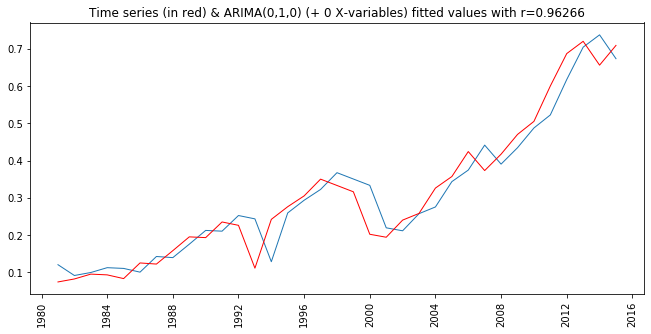


Last 10 of 36 observations:


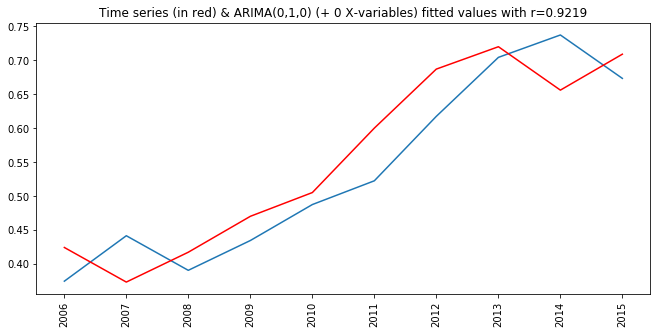

...compares with:


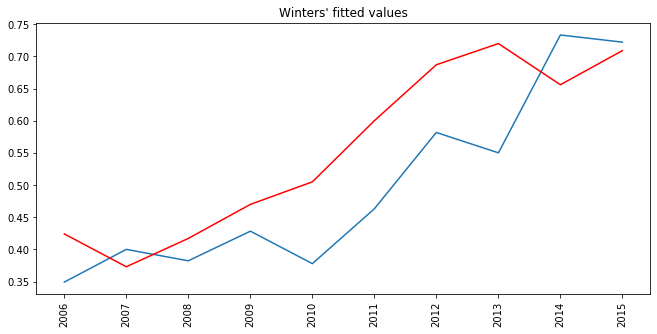

                              ARIMA Model Results                               
Dep. Variable:     D.Earnings Per Share   No. Observations:                   35
Model:                   ARIMA(0, 1, 0)   Log Likelihood                  54.561
Method:                             css   S.D. of innovations              0.051
Date:                  Sun, 05 Apr 2020   AIC                           -105.122
Time:                          16:06:51   BIC                           -102.011
Sample:                      01-01-1981   HQIC                          -104.048
                           - 01-01-2015                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0173      0.009      2.012      0.052       0.000       0.034

ARIMA Forecast [garbage if (p,d,q)≠(0,1,0)] for Earnings Per Share with AIC=-105.121675751162, BIC=-102.0109796281

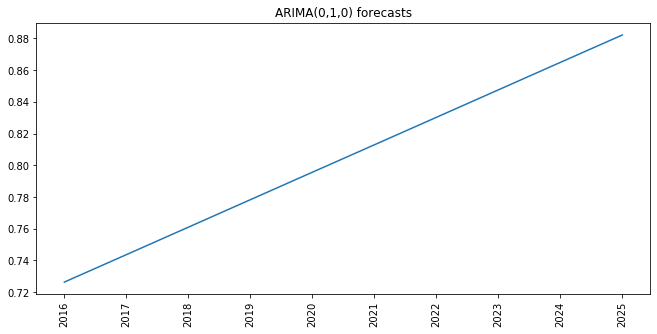

...compares with:


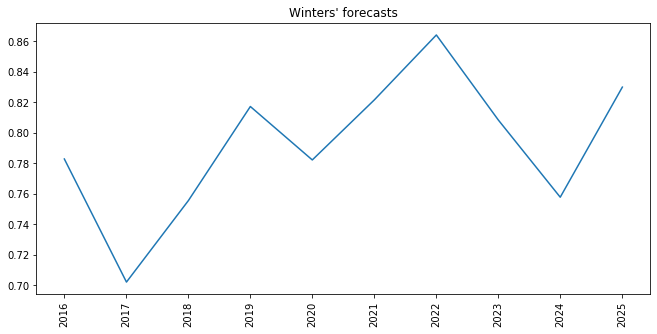

...compares with Decomposition's most-recent seasonal-index fit (not forecast; ignore the axes):


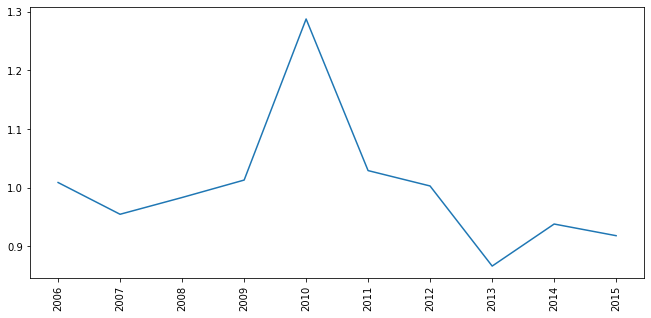

Analysis for time series "Earnings Per Share" took 14.64 mins.


In [27]:
#starting ARIMA iterations:

#start separately with d > 0 and d = 0, then follow the better line.

#from maximal model, try to find smaller d:
while True:
    print('Trying (p,d,q)=('+str(p)+','+str(d)+','+str(q)+')...')
    try:
        mf3 = ARIMA(df,order=(p,d,q), missing='raise').fit(trend='c', transparams=True)
        p0q = True if d == 0 else False #True: no need to do p,0,q later
        a2, b2, h2 = abh(mf3.aic, mf3.bic, mf3.hqic)
        if a2 != None and b2 != None and h2 != None:
            if mf3.tvalues.isnull().sum() == 0:
                i = True
                if 'a' in vars():
                    if a2 > a and b2 > b and h2 > h:
                        #all 3 are worse
                        i = False
                if i:
                    a = a2
                    b = b2
                    h = h2
                    bp = p
                    bd = d
                    bq = q
        if d > 0:
            d = d - 1
        else:
            #functional d not found; going onto p,0,q
            break
                
    except:
        if d > 0:
            d = d - 1
        else:
            #functional d not found; going onto p,0,q
            break
#found best d so far

i = 0
if 'bd' in vars():
    if bd != 0:
        i = 1
        d = bd
        print('Reverting to ...')
if i == 0:
    #find functional p & q:
    if 'p0q' in vars():
        if p0q:
            p, q = pq(p, q, mf3.tvalues, mf3.pvalues)
        else:
            q = q - 1
    else:
        q = q - 1
    
#start iteration for p,q:

while p >= 0 and q >= 0:
    #if s == 'start':
    #    s = ''
    #else:
    print('Trying (p,d,q)=('+str(p)+','+str(d)+','+str(q)+')...')
    try:
        #http://statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMA.fit.html
        #without transparams=True, may get: The computed initial AR coefficients are not stationary.
        #                                   You should induce stationarity.
        #mf3 = ARIMA(df,order=(p,d,q)).fit(transparams=True) #transform parameters to ensure stationarity
        mf3 = ARIMA(df,order=(p,d,q), missing='raise').fit(trend='c', transparams=True)
        #print(dir(mf3))
    except:
        #show next line for debugging:
        #mf3 = ARIMA(df,order=(p,d,q), missing='raise').fit(trend='c', transparams=True)
        if q >= p and q > 0:
            q = q - 1
        elif p > 0:
            p = p - 1
        else:
            break
            
        continue
    
    #ARIMA did not crash
    
    if p > 0 or q > 0:
        #qnull:
        qn = mf3.tvalues[p+1:].isnull().sum() if q > 0 else 0
        #pnull:
        pn = mf3.tvalues[1:p+1].isnull().sum() if p > 0 else 0
        #print('qn=',qn,', pn=',pn)
        if qn > 0:
            if qn >= pn:
                q = q - 1
            else:
                p = p - 1
            continue
            
        elif pn > 0:
            p = p - 1
            continue
            
        #qn == 0 and pn == 0; no nan values:
        #only check for small p-values here; should be done for all other sections
        elif max(mf3.pvalues[1:]) >= 0.05:
            pn = mf3.pvalues[p] if p > 0 else 0 #last p-value for p
            qn = mf3.pvalues[-1] if q > 0 else 0 #last p-value for q
            if qn >= pn:
                if qn >= 0.05:
                    q = q - 1
                    continue
                    
                else:
                    break
                    
            elif pn >= 0.05:
                p = p - 1
                continue
                    
            else:
                break
        
        else:
            break
            
    else:
        break

#No NaN; last p-values for p & q < 0.05

#if p < 0:
#    p = 0
#if q < 0:
#    q = 0

a2, b2, h2 = abh(mf3.aic, mf3.bic, mf3.hqic)

if a2 != None and b2 != None and h2 != None:
    i = True
    if 'a' in vars():
        if a2 > a and b2 > b and h2 > h:
            i = False
    if i:
        a = a2
        b = b2
        h = h2
        bp = p
        bd = d
        bq = q
        
#recorded best p,d,q & aic, bic, hqic

#got functional p & q, now search for d from d=0:

while d < 3:
    d = d + 1
    print('Trying (p,d,q)=('+str(p)+','+str(d)+','+str(q)+')...')
    #just in case:
    try:
        mf3 = ARIMA(df,order=(p,d,q)).fit(transparams=True)
    except:
        d = d - 1
        #print('Reverting to (p,d,q)=('+str(p)+','+str(d)+','+str(q)+') with AIC =', a, ', BIC =', b, ', HQIC =', h, '...')
        break

    else:
        a2, b2, h2 = abh(mf3.aic, mf3.bic, mf3.hqic)
        if a2 != None and b2 != None and h2 != None:
            if int(a2 < a) + int(b2 < b) + int(h2 < h) > 1:
                a = a2
                b = b2
                h = h2
                bd = d
                continue

            else:
                d = d - 1
                break

#found 'best' d; now search for 'best' p & q:

#restart with best p,d,q:

if p != bp or d != bd or q != bq:
    p = bp
    d = bd
    q = bq
    print('Reverting to (p,d,q)=('+str(p)+','+str(d)+','+str(q)+') with AIC =', a, ', BIC =', b, ', HQIC =', h, '...\n')
    mf3 = ARIMA(df,order=(p,d,q)).fit(transparams=True)

#pick either p or q to reduce:

while p > 0 or q > 0:
    if p > 0 and q > 0:
        pn = abs(mf3.tvalues[p])
        qn = abs(mf3.tvalues[-1])
        if (not pn != pn) and (not qn != qn):
            #both not nan
            if qn <= pn:
                q = q - 1
            else:
                p = p - 1
        #at least 1 nan:
        elif qn != qn:
            #qn is nan
            q = q - 1
        else:
            #pn is nan
            p = p - 1
    #exactly one of p or q = 0:
    elif q > 0:
        q = q - 1
    else: #must be p > 0
        p = p - 1
        
    while p >= 0 and q >= 0:
        print('Trying (p,d,q)=('+str(p)+','+str(d)+','+str(q)+')...')
        #just in case:
        try:
            mf3 = ARIMA(df,order=(p,d,q)).fit(transparams=True)
            #proceed below to see if this model is best so far
            rev = False #no need to revert to kept p,d,q values yet
            break
            
        except:
            #try to reduce either q or p and then redo mf3:
            if q >= p and q > 0:
                q = q - 1
            elif p > 0:
                p = p - 1
            else:
                #neither p nor q can be reduced; revert back to p,d,q kept earlier
                p = bp
                q = bq
                rev = True
                break
    
    if rev:
        break
    else:
        pass
    
    a2, b2, h2 = abh(mf3.aic, mf3.bic, mf3.hqic)
    #if a2 != a2 or b2 != b2 or h2 != h2:
    #    #at least one nan
    #    if p > 0 or q > 0:
    #        continue
    #        
    #    else:
    #        break
        
    if a2 <= a or b2 <= b or h2 <= h:
        a = a2
        b = b2
        h = h2
        bp = p
        bq = q
        
    #elif p == bp:
    #    #q < bq:
    #    q = q + 1
    #    bp = -1 #no further search on q
    #else:
    #    p = p + 1
    #    break
    #continue #search to (0,d,0), regardless
    
#at p,d,q=0,d,0

#if p > 0 or q > 0:
if bp > 0 or bq > 0:
    p = bp
    q = bq
    print('Reverting to (p,d,q)=('+str(p)+','+str(d)+','+str(q)+') with AIC =', a, ', BIC =', b, ', HQIC =', h, '...\n')
    mf3 = ARIMA(df,order=(p,d,q)).fit(transparams=True)
    #http://stackoverflow.com/questions/25044165/python-arima-exogenous-variable-out-of-sample

#if d<3, could try d=d+1 ...

#add any exogenous (X) variables:

if 'cn' in vars() or 'cn' in globals():
    del cn
if 'bcn' in vars() or 'bcn' in globals():
    del bcn
if 'dxf' in vars() or 'dxf' in globals():
    del dxf
if 'dx' in vars():
    def addx(dx, xdrop, dxt, nomore):
        #dx: current list of X-variables
        #dt: reserved list of potential X-variables
        dx.drop([xdrop], axis=1, inplace=True)
        if dxt.shape[1] > 0:
            xadd = dxt.iloc[:, 0].name
            print('Variable to add:', xadd)
            dx[xadd] = dxt.iloc[:, 0]
            dxt = dxt.iloc[:, 1:]
        else:
            if nomore == 0:
                nomore = 1
        print('')
        return dx, dxt, nomore
    
    if dx.shape[0] != dt.size:
        dxf = dx.iloc[dt.size:, :] #keep for forecast
        dx = dx.iloc[:dt.size, :] #drastically chop off the tail
        print('For fitting, extra rows removed at the end of exogenous X-variable matrix.')
    
    mx = 10 #max number of X variables used
    dx0 = dx.copy()
    xall = dx.shape[1]
    if xall > mx:
        nomore = 0 #there are still Xs in dxt
    else:
        nomore = 1 #truly no more Xs in dxt
    cnz = []
    mx1 = min(xall, mx)
    dxt = dx.iloc[:, mx1:].copy()
    dx = dx.iloc[:, :mx1]
    cn = list(dx)
    print('\nAdding exogenous X-variables, starting with', len(cn), 'of', xall, 'available:')
    print(cn,'\n')
    bcn = []
    
    fd1 = False #found 1 good solution
    
    #exogenous X-variable selection:
    
    while True:
        try:
            if dx.shape[1] == 0:
                if len(bcn) == mx and bcn != cnz:
                    cnz = bcn
                    #start deleting from best full model found:
                    dx = dx0[bcn].copy()
                    cn = list(dx)
                    print('Refining best model found with', mx, 'X-variables:', cn, '\n')
                    continue
                    
                mf3 = ARIMA(df, order=(p,d,q), missing='raise').fit(transparams=True)
            else:
                mf3 = ARIMA(df, order=(p,d,q), exog=dx, missing='raise').fit(transparams=True)
        except:
            cn = list(dx)
            if len(cn) > 0:
                dl1 = -1 if fd1 else 0 #delete 1st X if no good solution yet found, else delete last X
                print(len(cn),'X-Variables; 1 to delete:', cn[dl1])
                dx, dxt, nomore = addx(dx, cn[dl1], dxt, nomore)
                if nomore == 1:
                    nomore = 2
                    cnz = list(dx) #preserve the last full suite of X names
                continue
                
            else:
                if list(dx0) == list(dx) or bcn == []:
                    dx.drop(list(dx), axis=1, inplace=True)
                    cn = []
                    print('Reverting to (p,d,q)=('+str(p)+','+str(d)+','+str(q)+') with AIC =', a, ', BIC =', b, ', HQIC =',
                          h, '...')
                    mf3 = ARIMA(df, order=(p,d,q)).fit(transparams=True)
                else:
                    dx = dx0[bcn]
                    cn = list(dx)
                    print('Reverting to (p,d,q)=('+str(p)+','+str(d)+','+str(q)+') with AIC =', a, ', BIC =', b, ', HQIC =',
                          h, '&', len(bcn), 'X-variables', str(bcn)+'...')
                    mf3 = ARIMA(df, order=(p,d,q), exog=dx).fit(transparams=True)
                break
            
        if dx.shape[1] == 0:
            #print('Best Xs:', bcn)
            break
            
        cn = list(dx) #keep functional list of X-variables
        a2, b2, h2 = abh(mf3.aic, mf3.bic, mf3.hqic, prt=False)
        print(len(cn), 'X-variables with AIC =', a2, ', BIC =', b2, ', HQIC =', h2)
        try:
            tv = mf3.tvalues
        except:
            cn = list(dx)
            if len(cn) > 0:
                dl1 = -1 if fd1 else 0 #delete 1st X if no good solution yet found, else delete last X
                print(len(cn),'X-Variables; 1 to delete:', cn[dl1])
                dx, dxt, nomore = addx(dx, cn[dl1], dxt, nomore)
                if nomore == 1:
                    nomore = 2
                    cnz = list(dx) #preserve the last full suite of X names
                continue
                
            else:
                break
            
        tv2 = tv[1:-(p+q)]
        if a2 != a2 or b2 != b2 or h2 != h2 or tv.isnull().sum() > 0:
            #nan appears; remove 1 X
            if len(tv2) > len(tv2.dropna()):
                #print(mf3.tvalues[1:][hout.tvalues[1:] != mf3.tvalues[1:]].axes[0],"have 'nan's.")
                #the following uses the interesting result that '(np.nan != np.nan) == True' :
                xnan = tv2[tv2 != tv2].axes[0][-1] #last X with 'nan's
                print('Deleting', xnan, "with 'nan' for t-value.")
                dx, dxt, nomore = addx(dx, xnan, dxt, nomore)
                if nomore == 1:
                    nomore = 2
                    cnz = list(dx) #preserve the last full suite of X names
                continue
                
        #elif a2 <= a and b2 <= b and h2 <= h: #stricter than when searching for (p,d,q)
        #elif int(a2 <= a) + int(b2 <= b) + int(h2 <= h) > 1: #at least 2 better
        #elif a2 <= a or b2 <= b or h2 <= h:
        else:
            fd1 = True #found 1 good solution
            if (bcn == [] and a2 < a and b2 < b and h2 < h) or (bcn != [] and int(a2 < a) + int(b2 < b) + int(h2 < h) > 1):
                #if max(mf3.pvalues[1:-(p+q)]) < 0.05:
                    #worse p-value < 0.05
                    a = a2
                    b = b2
                    h = h2
                    bcn = cn.copy() #keep best list of X-variables
                    #fd1 = False #this last X improved the model; preserve it if new model crashes
        
        xdrop = tv[abs(tv) == min(abs(tv2))].axes[0][-1] #drop last of max t
        print('Variable to drop:',xdrop,'      ', 't-value =',tv[xdrop])
        dx, dxt, nomore = addx(dx, xdrop, dxt, nomore)
        if nomore == 1:
            nomore = 2
            cnz = list(dx) #preserve the last full suite of X names
        if dx.shape[1] == 0:
            #print('Best Xs:', bcn)
            break

    #end of X-variable selection
            
    #should try to see if could reduce p,d,q; but run out of bandwidth :(
    
    if cn != bcn:
        #latest functional list not best overall, need to revert back to best
        if bcn == []:
            print('\nNo X-variable selected.')
            print('\nFinal ARIMA reverting to (p,d,q)=('+str(p)+','+str(d)+','+str(q)+'):\n')
            mf3 = ARIMA(df, order=(p,d,q)).fit(transparams=True)
        elif 'dxf' in vars() or 'dxf' in globals():
            print('\nFinal ARIMA reverting to (p,d,q)=('+str(p)+','+str(d)+','+str(q)+') &',
                  len(bcn), 'X-variables', str(bcn)+':\n')
            mf3 = ARIMA(df, order=(p,d,q), exog=dx0[bcn]).fit(transparams=True)
        #elif bcn != []:
        else:
            print('Best ARIMA fit of (p,d,q)=('+str(p)+','+str(d)+','+str(q)+') with AIC =', a, ', BIC =', b, ', HQIC =',
                          h, '&', len(bcn), 'X-variables', str(bcn)+':')
            print(ARIMA(df, order=(p,d,q), exog=dx0[bcn]).fit(transparams=True).summary())
            print('\nForecast for exogenous X-variables not available!  Not using any X-variables...\n')
            #forecast X: https://stackoverflow.com/questions/34159342/extrapolate-pandas-dataframe/35960833#35960833
            mf3 = ARIMA(df, order=(p,d,q)).fit(transparams=True)

if 'dx' in vars() or 'dx' in globals():
    ipl(nr, nr, nb, mf3, df, p, d, q, dx0=dx0, bcn=bcn) #plot for up to 68 of range 
    ipl(period1, nr, nb, mf3, df, p, d, q, dx0=dx0, bcn=bcn) #plot for last cycle
else:
    ipl(nr, nr, nb, mf3, df, p, d, q)
    ipl(period1, nr, nb, mf3, df, p, d, q)
    
wtr = period1 #for Winters' later

print('...compares with:')
pl.plot(mf.fittedvalues[-period1:])
pl.plot(dt[-period1:], color='red')
pl.xticks(rotation=90)
pl.title("Winters' fitted values")
pl.show()

try:
    print(mf3.summary())
    if ('dxf' in vars() or 'dxf' in globals()) and bcn != []:
        #'predict' is for the differenced series, i.e. after 'd' of (p,d,q); just to get the shell for forecast:
        #prd = mf3.predict(start=df.shape[0], end=df.shape[0]+xtra-1, exog=dx0[bcn])
        prd = mf3.predict(start=df.shape[0], end=df.shape[0]+xtra-1, exog=dxf[bcn])
        print('\nARIMA Forecast [garbage if (p,d,q)≠('+str(p)+','+str(d)+','+str(q)+
              ')] for', dt.name, 'with AIC='+str(mf3.aic)+', BIC='+str(mf3.bic)+', HQIC='+str(mf3.hqic), '&',
                  len(bcn), 'X-variables', bcn, 'for', xtra, 'periods:')
        #'forecast' is for original series:
        prd.iloc[:]=mf3.forecast(xtra, exog=dxf[bcn])[0]
        wtr = xtra
    else:
        prd = mf3.predict(start=df.shape[0], end=df.shape[0]+period1-1) #for the differenced series, i.e. after 'd' of (p,d,q)
        print('\nARIMA Forecast [garbage if (p,d,q)≠('+str(p)+','+str(d)+','+str(q)+ ')] for', dt.name,
              'with AIC='+str(mf3.aic)+', BIC='+str(mf3.bic)+', HQIC='+str(mf3.hqic), 'for', period1, 'periods:')
        #df2=pd.DataFrame(mf3.forecast(period1)[0]) #not necessary
        prd.iloc[:]=mf3.forecast(period1)[0]
    print(prd)
    pl.xticks(rotation=90)
    pl.plot(prd)
    pl.title('ARIMA('+str(p)+','+str(d)+','+str(q)+') forecasts')
    pl.show()
except:
    print('\nNo feasible ARIMA solution!')
    print('Displaying errors for ARIMA(1,0,0) for', dt.name + ', regressing y on y(lag1):')
    print(ARIMA(df,order=(1,0,0)).fit(transparams=True).summary())
    #raise SystemExit

#!pip install pmdarima
#from pyramid.arima import auto_arima
#from pmdarima.arima import auto_arima
#mf3 = auto_arima(df, start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=1, D=1, trace=True,
#                           error_action='ignore', suppress_warnings=True, stepwise=True)
#print(mf3.aic)

#compares with Winters':
prd = mf.forecast(wtr) #same as above
#print(prd)
print('...compares with:')
pl.xticks(rotation=90)
pl.plot(prd)
pl.title("Winters' forecasts")
pl.show()

#compares with decomposition's seasonals:
print("...compares with Decomposition's most-recent seasonal-index fit (not forecast; ignore the axes):")
pl.xticks(rotation=90)
if wtr == period1:
    pl.plot(mf4.seasonal[-period1:])
else:
    #assuming wtr < period1
    pl.plot(mf4.seasonal[-period1:-(period1-wtr)])
pl.show()

##disgnostic plots:
#mf3.plot_diagnostics(figsize=(15, 12))
#pl.xticks(rotation=90)
#pl.show()

print('Analysis for time series "' + dt.name + '" took', '%.2f' % ((time.time() - stm) / 60), 'mins.')